<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

In [2]:
df = pd.read_csv('/datasets/taxi.csv')
print('Количество дубликатов в начальном датасете (с колонкой datetime):', df.duplicated().sum())
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi.sort_index(inplace=True)
display(taxi)

Количество дубликатов в начальном датасете (с колонкой datetime): 0


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Здесь изначально можно увидеть, что в начальном датасете дубликатов не было, это самое главное.

In [3]:
def data_info(data):
    print(50*'-')
    data.info()
    print('Описание количественных переменных')
    print(data.describe(percentiles=[.25, .5]))
    print(50*'-')
    print(f'Количество дубликатов в таблице = {data.duplicated().sum()}')

In [4]:
taxi.isna().sum()

num_orders    0
dtype: int64

NaN значений нет, что определённо радует.

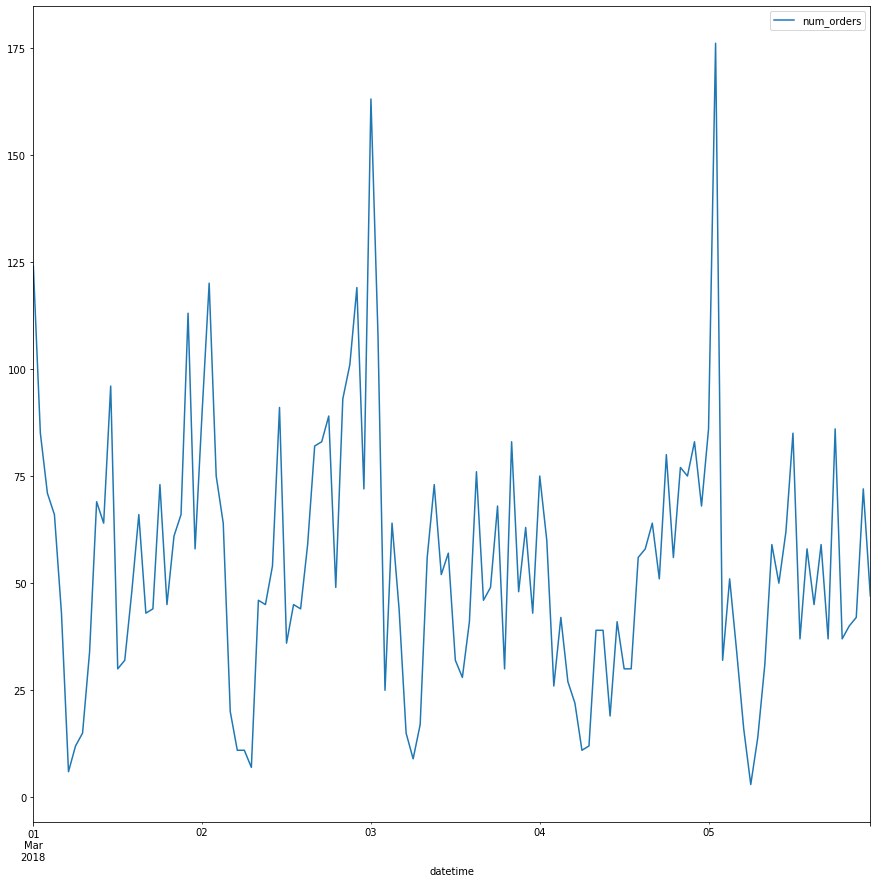

In [5]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi[:120].plot(figsize=(15,15))
taxi_1 = taxi.copy()

In [6]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(taxi['num_orders'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64


(array([ 20.,  51.,  41.,  79.,  61.,  66.,  81., 102., 145., 171., 147.,
        195., 226., 181., 231., 186., 240., 220., 159., 196., 184., 126.,
        170., 116., 125., 117., 102.,  82.,  52.,  62.,  56.,  40.,  47.,
         48.,  31.,  40.,  26.,  25.,  23.,  16.,  19.,  14.,  15.,   8.,
          6.,   7.,  10.,   3.,  10.,   4.,   4.,   3.,   1.,   6.,   4.,
          0.,   1.,   2.,   2.,   4.,   2.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.]),
 array([  0.  ,   4.62,   9.24,  13.86,  18.48,  23.1 ,  27.72,  32.34,
         36.96,  41.58,  46.2 ,  50.82,  55.44,  60.06,  64.68,  69.3 ,
         73.92,  78.54,  83.16,  87.78,  92.4 ,  97.02, 101.64, 106.26,
        110.88, 115.5 , 120.12, 124.74, 129.36, 133.98, 138.6 , 143.22,
        147.84, 152.46, 157.08

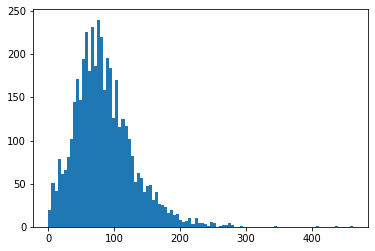

In [7]:
plt.hist(taxi['num_orders'], bins=100)

In [8]:
data_info(taxi)

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB
Описание количественных переменных
        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
max     462.000000
--------------------------------------------------
Количество дубликатов в таблице = 4165


В данном случае появление такого большого количество дубликатов объясняется тем, что одинаковых значений в столбце num_orders очень много, что может быть вполне нормальным явлением.

In [9]:
taxi[taxi.duplicated()]

,num_orders
datetime,
2018-03-01 15:00:00,66
2018-03-01 16:00:00,43
2018-03-01 21:00:00,66
2018-03-02 03:00:00,64
2018-03-02 06:00:00,11
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [10]:
display(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Разложим ряд на сезонную компоненту:

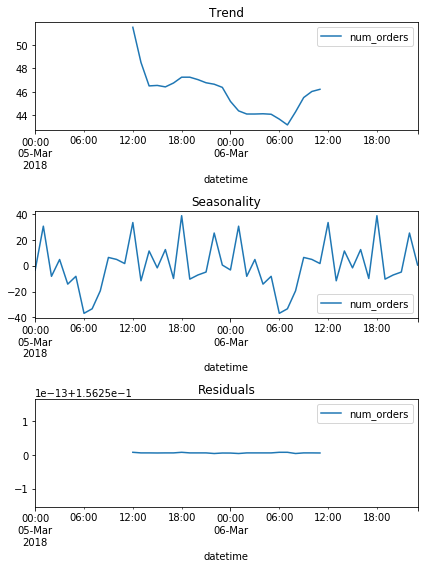

In [11]:
dec_0 = taxi['2018-03-05':'2018-03-06']
decomposed = seasonal_decompose(dec_0)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

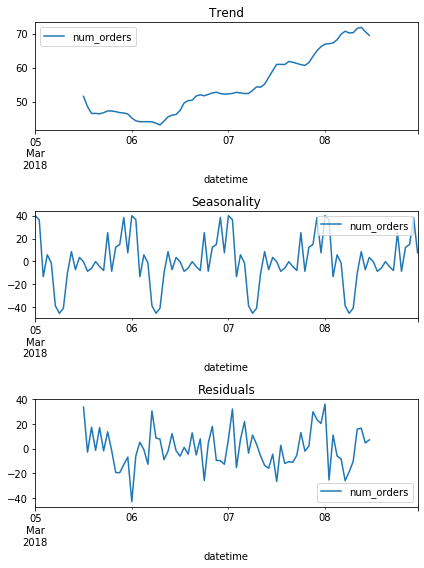

In [12]:
dec_1 = taxi['2018-03-05':'2018-03-08']
decomposed = seasonal_decompose(dec_1)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

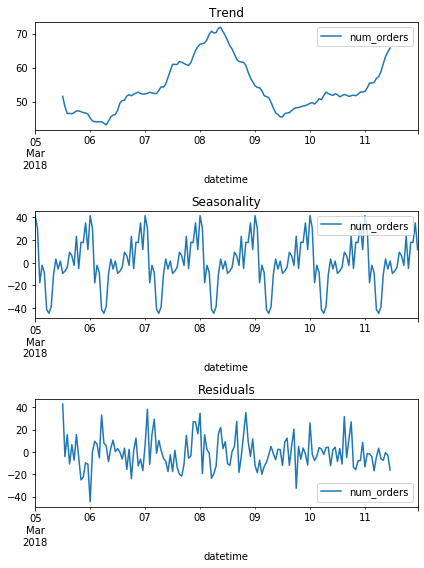

In [13]:
dec_2 = taxi['2018-03-05':'2018-03-11']
decomposed = seasonal_decompose(dec_2)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

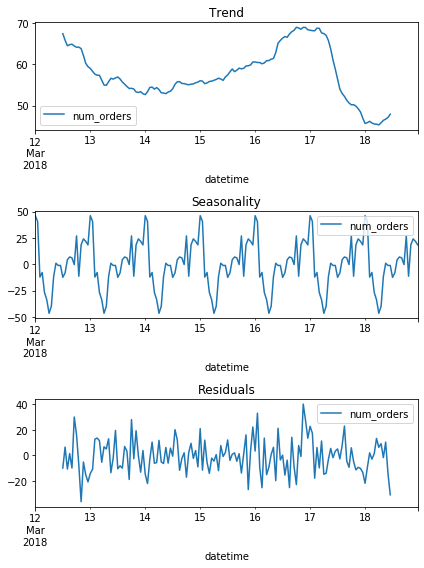

In [14]:
dec_3 = taxi['2018-03-12':'2018-03-18']
decomposed = seasonal_decompose(dec_3)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

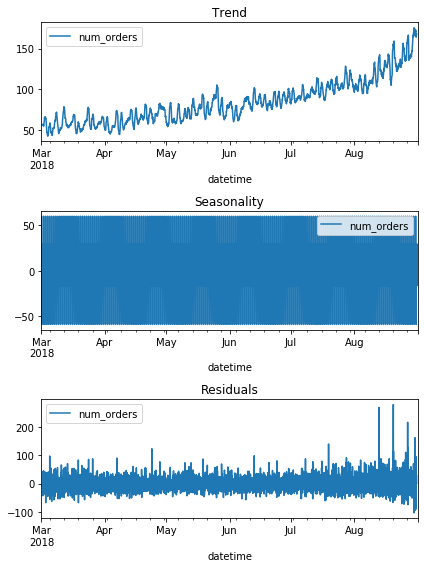

In [15]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд не является стационарным рядом, так как изменяется среднее значение.

<b>UPD_0: после проведения теста Дики-Фуллера убедился в том, что данное мнение оказалось ошибочным.</b>

In [16]:
#decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca()) 

In [17]:
#taxi = taxi - taxi.shift()
#taxi['mean'] = taxi['num_orders'].rolling(15).mean()
#taxi['std'] = taxi['num_orders'].rolling(15).std()
#taxi.plot()

Активность вызова такси приходится на вечерний период.

Промежуточные итоги: 

- в данных не содержится NaN значени, что не может не радовать;
- в хвостах нет выбросов;
- в данных присутствует тренд;
- <b>UPD_0:  по тесту Дики-Фуллера ряд всё таки является стационарным. Так как у меня не получалось обучить нормальные модели, делал предположения о нестационарности ряду и думал уже логорифмировать временной ряд, чтобы привести к стационарному. p-value 2.228638e-23 < 0.5, Нулевая гипотеза о стационарности временного ряда не отвергается; </b>
- <b>UPD_0: имеется восходящий тренд;</b>
- <b>UPD_0: из вышепостроенных графиков можно заключить следующее: сезонность такси, судя по графику, у нас чётко дневная; тренд восходящий, в теории может быть связан со временем года, но об этом говорить не может, так как данные у нас только за один год.</b>

## Анализ

In [18]:
#train, test = train_test_split(taxi, shuffle=False, test_size=0.2)

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
make_features(taxi, 168, 170)

<b>Было принято решение построить 168 лагов, так как это значения на неделю вперёд, таким образом модель будет лучше обучаться.</b>

In [21]:
a = taxi.corr()

for column in a.columns:
    for i in a[column]:
        if i > 0.8 and i < 1:
            print(column, i)

num_orders 0.8055687597966548
month 0.9158565721563577
lag_168 0.8055687597966548
rolling_mean 0.9158565721563577


In [22]:
#taxi = taxi.dropna()
data_info(taxi)
print('')
display(taxi)

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 174 entries, num_orders to rolling_mean
dtypes: float64(169), int64(5)
memory usage: 6.1 MB
Описание количественных переменных
        num_orders        month          day    dayofweek        hour  \
count  4416.000000  4416.000000  4416.000000  4416.000000  4416.00000   
mean     84.422781     5.505435    15.836957     3.005435    11.50000   
std      45.023853     1.713306     8.855229     1.990684     6.92297   
min       0.000000     3.000000     1.000000     0.000000     0.00000   
25%      54.000000     4.000000     8.000000     1.000000     5.75000   
50%      78.000000     5.500000    16.000000     3.000000    11.50000   
max     462.000000     8.000000    31.000000     6.000000    23.00000   

             lag_1        lag_2        lag_3        lag_4        lag_5  ...  \
count  4415.000000  4414.000000

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,154.288235
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,154.088235
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,154.188235


<b>Промежуточный итог:</b>

После того, как мы добавили дополнительные признаки дубликатов не стало, что хорошо.

In [23]:
#from sklearn.model_selection import TimeSeriesSplit
#X = taxi.drop(columns=['num_orders'])
#y = taxi['num_orders']
#tscv = TimeSeriesSplit(n_splits=2)
#print(tscv)

In [24]:
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)a
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

In [25]:
# LR_model = LinearRegression()
# LR_model.fit(X_train, y_train)
# predict = LR_model.predict(X_test)

# print("RMSE тестовой выборки:", sqrt(mean_squared_error(predict, y_test)))

# Деление выборок для обучения

In [26]:
taxi = taxi.dropna()

In [27]:
df_train, df_test = train_test_split(taxi, shuffle = False, test_size = 0.1)
train, valid = train_test_split(df_train, shuffle = False, test_size = 0.1)

In [28]:
for i in (df_train, df_test, train, valid):
    print('Размер', i.shape, i.index.is_monotonic)

Размер (3821, 174) True
Размер (425, 174) True
Размер (3438, 174) True
Размер (383, 174) True


In [29]:
X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']

X_valid = valid.drop(['num_orders'], axis = 1)
y_valid = valid['num_orders']

X_df_train = df_train.drop(['num_orders'], axis = 1)
y_df_train = df_train['num_orders']

X_df_test = df_test.drop(['num_orders'], axis = 1)
y_df_test = df_test['num_orders']

In [30]:
model = LinearRegression()

model.fit(X_train, y_train)

print("RMSE обучающей выборки:", mean_squared_error(y_true = y_train,
                                                    y_pred = model.predict(X_train)) ** 0.5)

print("RMSE валидационной выборки выборки: ", mean_squared_error(y_true = y_valid,
                                                    y_pred = model.predict(X_valid)) ** 0.5)

RMSE обучающей выборки: 19.389328223689944
RMSE валидационной выборки выборки:  29.02367965554416


In [31]:

model = DecisionTreeRegressor(max_depth = 6)

model.fit(X_train, y_train)

print("RMSE обучающей выборки:", mean_squared_error(y_true = y_train,
                                                    y_pred = model.predict(X_train)) ** 0.5)

print("RMSE валидационной выборки: ", mean_squared_error(y_true = y_valid,
                                                    y_pred = model.predict(X_valid)) ** 0.5)

RMSE обучающей выборки: 18.988221770069753
RMSE валидационной выборки:  35.779611622542404


In [32]:
time_split = TimeSeriesSplit(n_splits=10)

In [33]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

In [34]:
cat = CatBoostRegressor(iterations = 1000, verbose = False)
grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose = False, shuffle = False, cv=time_split)

In [35]:
grid_search_result['params']

{'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [36]:
cat = CatBoostRegressor(iterations = 1000, verbose = 500, learning_rate = 0.1, l2_leaf_reg = 1, depth = 6)

cat.fit(X_train, y_train)

print("RMSE обучающей выборки:", mean_squared_error(y_true = y_train,
                                                    y_pred = cat.predict(X_train)) ** 0.5)

print("RMSE валидационной выборки: ", mean_squared_error(y_true = y_valid,
                                                    y_pred = cat.predict(X_valid)) ** 0.5)

0:	learn: 34.4095309	total: 16.3ms	remaining: 16.3s
500:	learn: 6.5918997	total: 50.3s	remaining: 50.1s
999:	learn: 2.3869295	total: 1m 40s	remaining: 0us
RMSE обучающей выборки: 2.3869294684617834
RMSE валидационной выборки:  29.945812335186922


Промежуточный вывод:

- Лучше всего показали себя модели DecisionTree и CatBoost. Далее будем проверять их на тестовой выборке.

# Вывод

In [37]:
model.fit(X_df_train, y_df_train)
print("RMSE тестовой выборки: ", mean_squared_error(y_true = y_df_test,
                                                    y_pred = model.predict(X_df_test)) ** 0.5)

RMSE тестовой выборки:  51.50790430943966


In [38]:
cat.fit(X_df_train, y_df_train)
print("RMSE тестовой выборки: ", mean_squared_error(y_true = y_df_test,
                                                    y_pred = cat.predict(X_df_test)) ** 0.5)

0:	learn: 36.8447846	total: 59.4ms	remaining: 59.3s
500:	learn: 7.4805657	total: 52.8s	remaining: 52.5s
999:	learn: 2.7270316	total: 1m 45s	remaining: 0us
RMSE тестовой выборки:  37.90165359310984


<b>Вывод:</b> самым лучшим методом оказался CatBoost с параметрами {'depth': 4, 'l2_leaf_reg': 3, 'learning_rate': 0.03}.

<b>UPD_1:...с параметрами {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.1}. </b>

In [ ]:
'''
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()
display(train)
display(test)
print(train.index.min(), train.index.max())
#print(train['hour'].min(), train['hour'].max())
print(test.index.min(), test.index.max())
#print(test['hour'].min(), test['hour'].max())
'''

In [ ]:
'''
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']
'''

In [ ]:
#target_test

In [ ]:
'''
LR_model = LinearRegression()
LR_model.fit(features_train, target_train)
predict = LR_model.predict(features_test)

print("RMSE тестовой выборки:", sqrt(mean_squared_error(predict, target_test)))
'''

Линейная регрессия достаточно хорошо обучилась на данных, что не вызывает никаких вопросов.

In [ ]:
'''
plt.figure(figsize=(15,15))
plt.plot(test['hour'], target_test)
plt.plot(test['hour'], predict)
'''

In [ ]:
#print (predict)

<b>Линейная регрессия</b>

In [ ]:
'''
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score

train_1, other_1 = train_test_split(taxi, shuffle=False, test_size=0.2)
valid_1, test_1 = train_test_split(other_1, shuffle=False, test_size=0.5)
train_1 = train_1.dropna()


X_1_0 = train_1.drop('num_orders', axis = 1)
y_1_0 = train_1['num_orders']
X_2_0 = valid_1.drop('num_orders', axis = 1)
y_2_0 = valid_1['num_orders'] 
X_3_0 = test_1.drop('num_orders', axis = 1)
y_3_0 = test_1['num_orders'] 

for depth in range(1, 51):
    model_1_1 = DecisionTreeRegressor(random_state = 12345, max_depth=depth)
    model_1_1.fit(X_1_0, y_1_0)
    predictions_valid = model_1_1.predict(X_2_0)

    print("max_depth =", depth, ": ", end='')
    print("RMSE валидацонной выборки:", (mean_squared_error(y_2_0, predictions_valid))**0.5)
'''

In [ ]:
'''
model_1 = DecisionTreeRegressor(random_state = 12345, max_depth = 5)
model_1.fit(X_1_0, y_1_0)
pr_test = model_1.predict(X_3_0)
print("RMSE тестовой выборки:", (mean_squared_error(y_3_0, pr_test))**0.5)
'''

print(y_3_0)

In [ ]:
'''
from sklearn.ensemble import RandomForestRegressor #случайный лес

best_model_3_0_1 = None
best_result_3_0_1 = 0
best_est = 0
for est in range(1, 26):
    for depth in range(1, 51):
        model_3_0_1 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_3_0_1.fit(X_1_0, y_1_0)
        predictions_valid = model_3_0_1.predict(X_2_0)
        result_3_0_1 = (mean_squared_error(y_2_0, predictions_valid))**0.5
        #if result_3_0_1 < 48:
            #best_model_3_0_1 = model_3_0_1
            #best_result_3_0_1 = result_3_0_1
            #best_est = est
        print(result_3_0_1, 'количество деревьев:', est, 'глубина:', depth)
        '''

In [ ]:
#print("Accuracy наилучшей модели случайного леса на валидационной выборке:", best_result_3_0_1, 'с количеством деревьев', best_est)

In [ ]:
'''
model_RF = RandomForestRegressor(random_state=12345, n_estimators=15, max_depth=23)
model_RF.fit(X_1_0, y_1_0)
pr_test_RF = model_RF.predict(X_3_0)
print("RMSE тестовой выборки:", (mean_squared_error(y_3_0, pr_test_RF))**0.5)
'''

# ВЫВОД: каждая модель показала неплохой результат, но самой хорошей и самой быстрой из всех оказалась LR.